**Pothole Detection**

This Pothole Detection System uses advanced machine learning and image processing technologies to identify and locate potholes on roads, aiming to enhance road safety and streamline maintenance operations. At its heart, the system uses Convolutional Neural Networks (CNN) model to analyze images and detectes potholes in real-time.


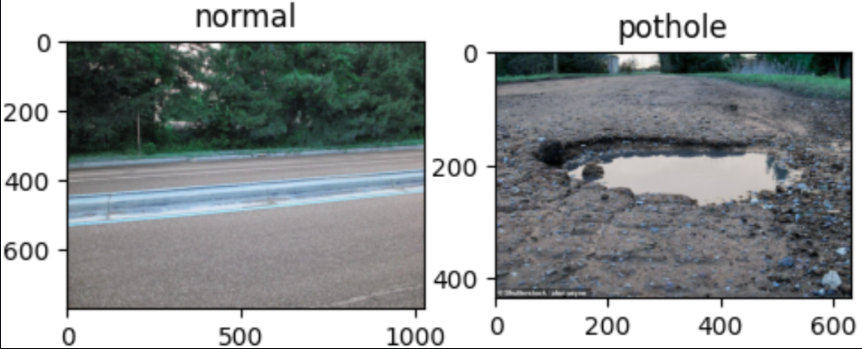

*Dataset information:*

PotholeDataset

This dataset was exported from Kaggle which includes approximately 1000 images of normal road iamges and pothole images.

**STEP 1:** We define the root directory paths for storing and accessing data across different environments:

- `LOCAL_ROOT`: This variable is set to `'/Users/neochoon/Data/PotHole'`, which specifies the path on a local environment.
- `COLAB_ROOT`: The `'/content/drive/MyDrive/data'` path is designated for Google Colab users.
- `KAGGLE_ROOT`: Finally, `'/kaggle/input'` is the path used within Kaggle environments.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#colab
COLAB_ROOT = '/content/drive/MyDrive/Pothole/Dataset'

**STEP 2:** Importing all the needed libraries

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

The code snippet is designed to gather all `.jpg` image paths from a specified directory and its subdirectories into a list named `imagepaths`.

In [5]:
import os

# run in local env
data_root = COLAB_ROOT

imagepaths = []

for dirname, _, filenames in os.walk(data_root):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        if (path.endswith('.jpg') == False):
            continue
        #print(path)
        imagepaths.append(path)

print("Image count :", len(imagepaths))

Image count : 955


**CHECKING IMAGES FOR CONFIRMATION**

In [6]:
import random

selected_images = random.sample(imagepaths, 10)
display(selected_images)

['/content/drive/MyDrive/Pothole/Dataset/Pothole/337.jpg',
 '/content/drive/MyDrive/Pothole/Dataset/PlainRoad/35.2filtro_cabecera.jpg',
 '/content/drive/MyDrive/Pothole/Dataset/Pothole/291.jpg',
 '/content/drive/MyDrive/Pothole/Dataset/Pothole/529.jpg',
 '/content/drive/MyDrive/Pothole/Dataset/Pothole/144.jpg',
 '/content/drive/MyDrive/Pothole/Dataset/Pothole/175.jpg',
 '/content/drive/MyDrive/Pothole/Dataset/PlainRoad/2.federation-way-1.jpg',
 '/content/drive/MyDrive/Pothole/Dataset/PlainRoad/229.thinkstockphotos-483482839-hires.jpg',
 '/content/drive/MyDrive/Pothole/Dataset/PlainRoad/4.jpg',
 '/content/drive/MyDrive/Pothole/Dataset/Pothole/333.jpg']

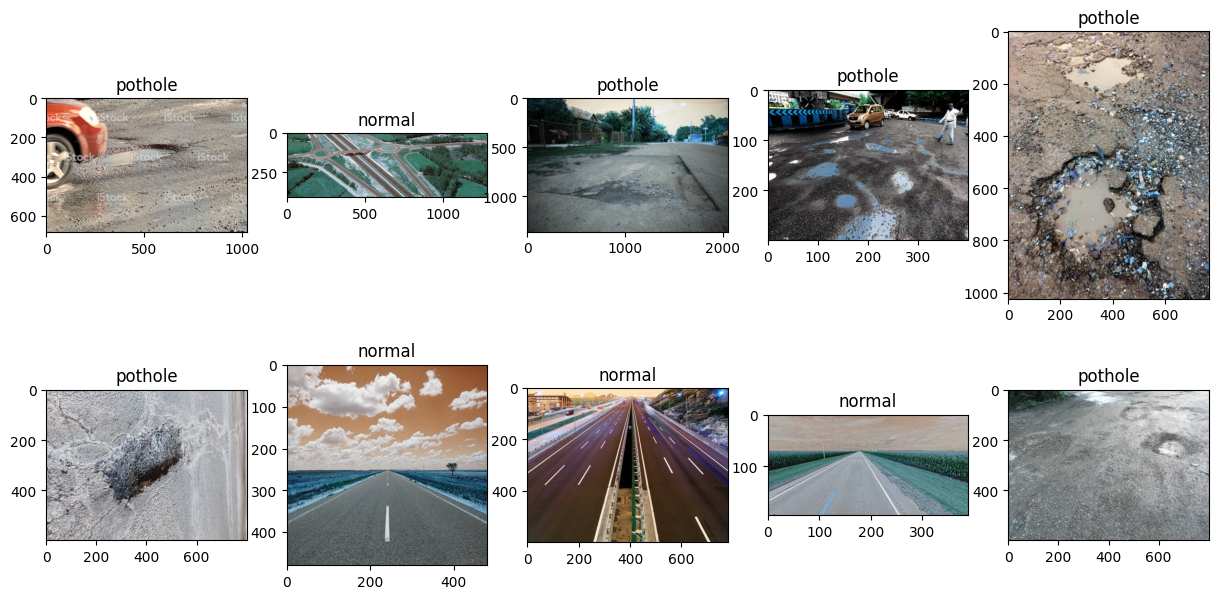

In [7]:
fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(15,15)

for i in range(2):
    for j in range (5):
        #l=rn.randint(0,len(y))
        imagepath=selected_images[i*5+j]
        label = "normal" if "PlainRoad" in imagepath else "pothole"
        ax[i,j].imshow(cv2.imread(imagepath))
        ax[i,j].set_title(label)
        ax[i,j].set_aspect('equal')

**STEP 3:** Data Preprocessing

****Splitting dataset into training and validation and preprocessing the training set****

In [8]:
from keras.preprocessing.image import ImageDataGenerator

# Training ImageDataGenerator, using data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2)

# Validation ImageDataGenerator, remove data augmentation
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)



In [31]:
training_set = train_datagen.flow_from_directory(data_root,
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 subset="training")

Found 788 images belonging to 2 classes.


**Preprocessing the validation set**

In [32]:

validation_generator = validation_datagen.flow_from_directory(data_root,
                                            target_size=(128, 128),
                                            batch_size=32,
                                            class_mode='binary',
                                            subset='validation')

Found 196 images belonging to 2 classes.


**STEP 4:** Model Training

Training the model involves feeding it our dataset of images, allowing it to learn to distinguish between potholes and no potholes. We utilize a loss function and an optimizer to measure and improve its performance. This process is iterative, with the model gradually improving its accuracy over time.

**Initialising the CNN**

Our CNN model consists of several layers designed to extract and learn from the features of the images. This includes convolutional layers for feature detection, pooling layers to reduce dimensionality, and fully connected layers for classification.



**- Convolution**

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten
from tensorflow.keras.layers import Dropout

cnn = Sequential()

cnn.add(Conv2D(filters=32, kernel_size=5, padding="same", activation='relu', input_shape=[128, 128, 3]))
cnn.add(MaxPool2D(pool_size=2, strides=2))

cnn.add(Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'))
cnn.add(MaxPool2D(pool_size=2, strides=2))

cnn.add(Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'))
cnn.add(MaxPool2D(pool_size=2, strides=2))

#cnn.add(Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'))
#cnn.add(MaxPool2D(pool_size=2, strides=1))

#cnn.add(Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'))
#cnn.add(MaxPool2D(pool_size=2, strides=1))

**- Flattening & Dropout**

In [12]:
cnn.add(Flatten())
cnn.add(Dropout(0.4))

**- Full Connection**

In [13]:
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

**- Output Layer**

In [14]:
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
#cnn.add(tf.keras.layers.Dense(units=2, activation='softmax'))

**Training the CNN**

**Compiling the CNN**

In [15]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 128)       0

In [19]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)


**Training the CNN on the Training set and evaluating it on the Validation set**

In [20]:
cnn.fit(x = training_set,
        validation_data = validation_generator,
        epochs = 25,
        callbacks=[early_stopping])

Epoch 1/25
19/25 [=====================>........] - ETA: 43s - loss: 0.7548 - accuracy: 0.5570

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 [==============================] - 229s 9s/step - loss: 0.7416 - accuracy: 0.5596 - val_loss: 0.6523 - val_accuracy: 0.7857
Epoch 2/25
25/25 [==============================] - 48s 2s/step - loss: 0.5747 - accuracy: 0.7157 - val_loss: 0.4817 - val_accuracy: 0.8010
Epoch 3/25
25/25 [==============================] - 52s 2s/step - loss: 0.4285 - accuracy: 0.8211 - val_loss: 0.3582 - val_accuracy: 0.8316
Epoch 4/25
25/25 [==============================] - 53s 2s/step - loss: 0.3716 - accuracy: 0.8541 - val_loss: 0.3491 - val_accuracy: 0.8469
Epoch 5/25
25/25 [==============================] - 47s 2s/step - loss: 0.3060 - accuracy: 0.8756 - val_loss: 0.2798 - val_accuracy: 0.8929
Epoch 6/25
25/25 [==============================] - 52s 2s/step - loss: 0.3182 - accuracy: 0.8769 - val_loss: 0.3396 - val_accuracy: 0.8418
Epoch 7/25
25/25 [==============================] - 46s 2s/step - loss: 0.2973 - accuracy: 0.8718 - val_loss: 0.2246 - val_accuracy: 0.9082
Epoch 8/25
25/25 [============

**STEP 5:** Making a single prediction

1/1 [==============================] - 0s 34ms/step


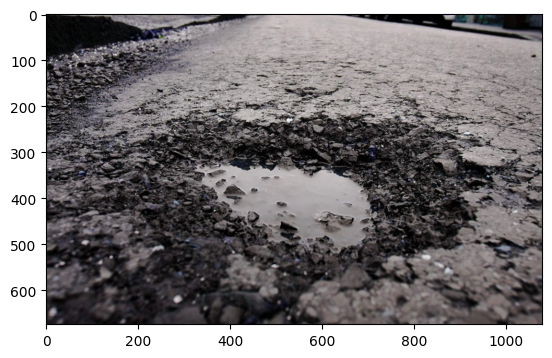

In [27]:
import numpy as np
from keras.preprocessing import image
ramdom_image_path = random.sample(imagepaths, 1)[0]

plt.imshow(cv2.imread(ramdom_image_path))
test_image = image.load_img(ramdom_image_path, target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
#training_set.class_indices
if result[0][0] == 1:
  prediction = 'pothole'
else:
  prediction = 'normal'

In [28]:
print(prediction)

pothole


**STEP 6:** Model Evaluation

After training, we evaluate our model's performance using metrics like accuracy, precision, recall, and the F1 score. These metrics give us insight into how well our model can identify potholes in unseen images, guiding us on where to make improvements.

In [30]:
# Predicting the Validation set results
from sklearn.metrics import classification_report, confusion_matrix

# Predict the whole validation set
Y_pred = cnn.predict(validation_generator, len(validation_generator))
# Convert predictions classes to one hot vectors
Y_pred_classes = np.where(Y_pred > 0.5, 1, 0)  # The model outputs probabilities by default
# Convert validation observations to one hot vectors
Y_true = validation_generator.classes  # Get the true labels
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# print the confusion matrix
print("Confusion Matrix:")
print(confusion_mtx)

# Display detailed evaluation metrics
print("\nClassification Report:")
print(classification_report(Y_true, Y_pred_classes, target_names=['Normal', 'Pothole']))

7/7 [==============================] - 4s 523ms/step
Confusion Matrix:
[[24 49]
 [44 79]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.35      0.33      0.34        73
     Pothole       0.62      0.64      0.63       123

    accuracy                           0.53       196
   macro avg       0.49      0.49      0.48       196
weighted avg       0.52      0.53      0.52       196

